# Map-match a track on a network

<div style='text-align:justify'>
In the context of the <b>Tracklib</b> library, the map-matching technique aims to relate GPS track observations with edges in a reference network by applying the Hidden Markov Model (HMM) algorithm proposed by Newson and Krumm (2009) [1].
<br/>
The algorithm, for each point to be map-matched, takes into account both the preceding and succeeding points, thereby ensuring overall trajectory consistency. This approach is particularly well suited for matching tracks on dense networks.
<br/>
However, it can also be highly valuable in mountain environments. For instance, when two trails run alongside a stream, the algorithm prevents crossings if no infrastructure (such as a bridge) is present.
</div>

<figure style='text-align:center;padding:1.5em'>
<img src="mapmatching_process1.png"  width="650" />
<figcaption><br/>Figure 1: Map-matching process of GPS observations to the road network (images adapted from [2])</figcaption>
</figure>

<div style='text-align:justify'>
Figure 1 illustrates: <ul>
    <li>on left: the input data (GPS points on a road network), </li>
    <li>in the middle: the concept of the map-matching process to a network (using the Viterbi algorithm), </li>
    <li>and the resulting output (the geometric projection of the points onto the road segments to which they have been assigned).</li>
</ul></div>

<br/>

In Tracklib, the function to map-match a track on a network is:
<div class="alert alert-block alert-warning" style="padding:1em"><b><i style='padding-left:4em'>mapOnNetwork (tracks, network, search_radius)</i></b>
</div>
With:<ul>
<li> tracks (TrackCollection): collection of Tracks</li>
<li> network (Network): the road network</li>
<li> search_radius (float): the search radius in meter</li>
</ul>

<br/>

Results are stored in Analytical Features (AF) for each track point <i>k</i>:
<ul>
    <li>trace["hmm_inference", k][0]: geometric projection (*ENUCoords*) </li>
    <li>trace["hmm_inference", k][1]: index of the edge onto which the point is projected (*int*), -1 if the point is not map-matched</li>
    <li>trace["hmm_inference", k][2]: distance between the map-matched point and the start vertex</li>
    <li>trace["hmm_inference", k][3]: distance between the map-matched point and the end vertex</li>
    <li>trace["obs_noise", k] (type int)</li>
    <li>trace["hmm_cost", k] (type float)</li>
</ul>

<br/>

<div class="alert alert-block alert-info" style='text-align:justify'>
    <b>Reference:</b><br/>[1] - Newson, P., & Krumm, J. (2009). <i>Hidden Markov map matching through noise and sparseness.</i> Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, GIS ‘09, ACM, New York, NY, USA, pp. 336–343. <a href='https://doi.org/10.1145/1653771.1653818'>https://doi.org/10.1145/1653771.1653818</a><br/>
    [2] - Yann Meneroux. Méthodes d'apprentissage statistique pour la détection de la signalisation routière à partir de véhicules traceurs. Technologies Émergeantes [cs.ET]. Université Paris-Est, 2019. Français. ⟨NNT : 2019PESC2061⟩. <a href='https://theses.hal.science/tel-02493936v1/file/TH2019PESC2061.pdf'>PDF</a>
</div>

## Let's start by importing tracklib library

In [1]:
import math
import matplotlib.pyplot as plt
import os
import sys

#-------------------------------------------------------
# 1. [if tracklib is not installed using pip] add tracklib's local path in the python path
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# 2. Import
import tracklib as trk

## Loading GPS points

In this tutorial, data points are stored in a csv file. The first line contained header with names of columns:  
<div style='margin-left:4em'><i>X,Y,track_fid,track_seg_id,track_seg_point_id,ele,time</i></div>

Coordinates is provided in Geographic system reference and separtor caracter is the comma. The time's format is: <i>“4Y/2M/2D 2h:2m:2s”</i>

In [2]:
# Specify time format
trk.ObsTime.setReadFormat("4Y/2M/2D 2h:2m:2s")

# local file path
trackpath = '../../../data/csv/22245.csv'

# Loading GPS points
param = trk.TrackFormat({'ext': 'CSV', 'id_E':0, 'id_N':1, 'id_U':2, 'id_T':3, 'srid': "Geo", 'header': 1, 'separator': ','})
trace = trk.TrackReader.readFromFile(trackpath, param, verbose=False)

# Transform geographic coordinates in local projection
trace.toENUCoordsIfNeeded()

# Point 37 is forced to be outlier, so it will not to be map-matched
trace[37].position.setX(trace[37].position.getX() - 45)
trace[37].position.setY(trace[37].position.getY() - 15)

# Display a little summary of information of the GPS track:
trace.summary()

-------------------------------------
GPS track #22245 of user 0:
-------------------------------------
  Nb of pt(s):   52
  Ref sys id   : ENU
  Starting at  : 12/07/2019 15:42:35
  Ending at    : 12/07/2019 16:48:16
  Duration     : 3941.000 s
  Length       : 1380.857 m
-------------------------------------



## Loading the road network

Data network are stored in a csv file. The first line contained header with names of columns:  
<div style='margin-left:4em'><i>WKT,link_id,source,target,direction</i></div>



In [3]:
netpath = '../../../data/network/network-utgtrack-22245.csv'
network = trk.NetworkReader.readFromFile(netpath, formatfile='VTT', verbose=False)

# Transform geographic coordinates in local projection
network.toENUCoords(trace.base)

# Print number of edges and nodes of the network
print ('Number of edges = ', len(network.EDGES))
print ('Number of nodes = ', len(network.NODES))
print ('Total length of all edges = ', network.totalLength())

Number of edges =  288
Number of nodes =  216
Total length of all edges =  19386.544826479814


## Display GPS points on the road network

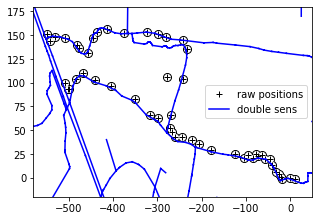

In [4]:
plt.figure(figsize = (5, 3.5))

trace.plotAsMarkers(append=True, label='raw positions')
network.plot('b-', '', '', '', 1.5, plt)

plt.xlim([-580, 50]) 
plt.ylim([-20, 180])
plt.legend(loc=7)
plt.show()

## Prepare and launch the map matching process

In [5]:
si = trk.SpatialIndex(network, verbose=False)
network.spatial_index = si



In [6]:
# computes all distances between pairs of nodes
network.prepare()



  0% (0 of 216) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Map-matching preparation...


100% (216 of 216) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


In [7]:
print ('Launching Map-matching')
# Map track on network
trk.mapOnNetwork(trace, network, search_radius=25, debug=False)

# Few statistics:
print ('')
print ('Few statistics results:')

print ('    Number of points = ', trace.size())
# Nombre de points map-matchés:
nbmm = 0
nbhp = 0
cumuldist = 0
for k in range(len(trace)):
    ide = trace["hmm_inference", k][1]
    if ide == -1:
        nbhp += 1
    else:
        nbmm += 1
        pmm = trace["hmm_inference", k][0]
        pi = trace[k].position
        d = pi.distance2DTo(pmm)
        cumuldist += d

percentMM = (nbmm / trace.size() * 100)
print ('    Number of map-matched points = ' + str(nbmm) + ' (' + str(round(percentMM, 2)) + ' %)')
percentHP = (nbhp / trace.size() * 100)
print ('    Number of off-road = '+ str(nbhp) + ' (' + str(round(percentHP, 2)) + ' %)') 

# Calcul du RMSE
rmse = round(math.sqrt(d/nbmm),2)
print ('    GPS standard error = ' + str(rmse) + ' m')


Launching Map-matching

Few statistics results:
    Number of points =  52
    Number of map-matched points = 51 (98.08 %)
    Number of off-road = 1 (1.92 %)
    GPS standard error = 0.2 m


## Display results 

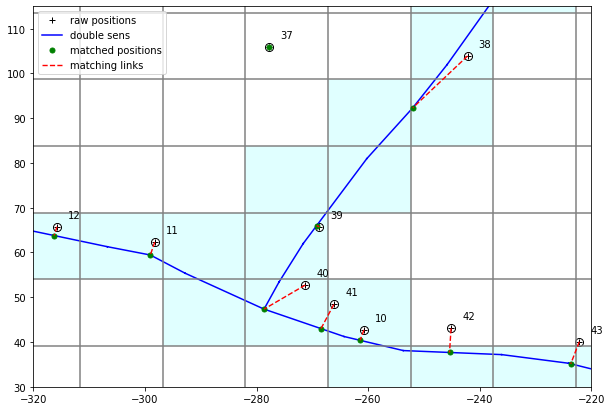

In [8]:
plt.figure(figsize = (10, 7))

xmin = -320
xmax = -220 
plt.xlim([xmin, xmax]) 
ymin = 30
ymax = 115
plt.ylim([ymin, ymax])

trace.plotAsMarkers(append=True, label='raw positions')
network.plot('b-', '', '', '', 1.5, plt)
si.plot(base=False, append=True)

for k in range(len(trace)):
    xp = trace[k].position.getX()
    yp = trace[k].position.getY()
    if xp >= xmin and xp <= xmax and yp >= ymin and yp <= 115:
        plt.text(xp+2, yp+2, str(k))
    
    xmm = trace["hmm_inference", k][0].getX()
    ymm = trace["hmm_inference", k][0].getY()
    plt.plot(xmm, ymm, 'go', markersize=5, label='matched positions' if k == 0 else "")
    
    X = [xp, xmm]
    Y = [yp, ymm]
    plt.plot(X, Y, "r--", linewidth=1.4, label='matching links' if k == 0 else "")
plt.legend()

As expected, observation 37 is not map-matched: the index of the edge onto which the point is projected has value *"-1"

In [9]:
print ('')
print ('Index of the edge onto which the point is projected: ', trace["hmm_inference", 37][1])

# Distance to the raw observation is 0
p = trace["hmm_inference", 37][0]
d = trace[37].position.distance2DTo(p)
print ('Distance to the raw observation = ', d)


Index of the edge onto which the point is projected:  -1
Distance to the raw observation =  0.0


Note that observation 40 is map-matched on a node if the network and not on an edge. 

In [10]:
print ('')
print ('Distance between the map-matched point and the start vertex: ', trace["hmm_inference", 40][2], ' m')
print ('Distance between the map-matched point and the end vertex: ', round(trace["hmm_inference", 40][3], 2), ' m')


Distance between the map-matched point and the start vertex:  0.0  m
Distance between the map-matched point and the end vertex:  245.84  m
